This notebook is used to create the runtime graphs for the BiG-SCAPE v2 paper

In [102]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set_theme(style="white")

COLOR_MAP = "colorblind"

sns.color_palette(COLOR_MAP)

COLORS = {
    "bigscape_blue": "#52A3A3",
    "dark_blue": "#0E75BB",
    "orange_i_found_on_bigscape_image": "#F7931E",
    "antismash_red": "#AA0000",
    "bigslice_grey": "#515154",
}

totals_colors = [
    COLORS["bigslice_grey"],
    COLORS["bigslice_grey"],
    COLORS["bigscape_blue"],
    COLORS["bigscape_blue"],
]

# make the font type editable in the svg
mpl.rcParams["svg.fonttype"] = "none"

In [ ]:
# load data
# bs1 csv: size,sample,start,hmm_scan,hmm_align,distance_calc,cc_gen,total
bigscape_v1_matrix = pd.read_csv("bigscape_v1_matrix.csv")
# bs2 csv: size,sample,start,hmm_scan,hmm_scan_save,hmm_align,hmm_align_save,distance_calc,cc_gen,cc_gen_save,total
bigscape_v2_matrix = pd.read_csv("bigscape_v2_matrix.csv")

# for v2 we want to combine the saving steps with their preceding steps
bigscape_v2_matrix["hmm_scan"] = bigscape_v2_matrix["hmm_scan"] + bigscape_v2_matrix["hmm_scan_save"]
bigscape_v2_matrix["hmm_align"] = bigscape_v2_matrix["hmm_align"] + bigscape_v2_matrix["hmm_align_save"]
bigscape_v2_matrix["cc_gen"] = bigscape_v2_matrix["cc_gen"] + bigscape_v2_matrix["cc_gen_save"]

# then drop the saving columns
bigscape_v2_matrix = bigscape_v2_matrix.drop(columns=["hmm_scan_save", "hmm_align_save", "cc_gen_save"])


# bs2 mode csvs. same as bs2 csvs

bigscape_v2_mode_matrix = pd.read_csv("bigscape_v2_mode_matrix.csv")
# this matrix has the full folder names as samples. they are in the form of output_v2_Amycolatopsis_legacy_1
# cut down to the relevant part
bigscape_v2_mode_matrix["sample"] = bigscape_v2_mode_matrix["sample"].str.split("_").str[3:-1]
bigscape_v2_mode_matrix["sample"] = bigscape_v2_mode_matrix["sample"].str.join("_")

# average out per sample
bigscape_v2_mode_matrix = bigscape_v2_mode_matrix.groupby(["sample"]).mean()


# 10k mode csvs
bigscape_v2_mode_10k_matrix = pd.read_csv("bigscape_v2_mode_10k_matrix.csv")
# similar to the other mode matrix, cut down the samples
bigscape_v2_mode_10k_matrix["sample"] = bigscape_v2_mode_10k_matrix["sample"].str.split("_").str[3:-1]
bigscape_v2_mode_10k_matrix["sample"] = bigscape_v2_mode_10k_matrix["sample"].str.join("_")

# average out per sample
bigscape_v2_mode_10k_matrix = bigscape_v2_mode_10k_matrix.groupby(["sample"]).mean()

# bigslice csvs, both are: size,sample,start,total
bigslice_v1_matrix = pd.read_csv("bigslice_v1_matrix.csv")
bigslice_v2_matrix = pd.read_csv("bigslice_v2_matrix.csv")

# use size and sample as index
bigscape_v1_matrix = bigscape_v1_matrix.set_index(["size", "sample"])
bigscape_v2_matrix = bigscape_v2_matrix.set_index(["size", "sample"])
# modes runs do not have sample sizes, or at least it's not relevant
# bigscape_v2_mode_matrix = bigscape_v2_mode_matrix.set_index(["sample"])
# bigscape_v2_mode_10k_matrix = bigscape_v2_mode_10k_matrix.set_index(["sample"])

bigslice_v1_matrix = bigslice_v1_matrix.set_index(["size", "sample"])
bigslice_v2_matrix = bigslice_v2_matrix.set_index(["size", "sample"])

# collate totals dataframes
# these are used for the scatter plots
totals = pd.DataFrame(index=bigscape_v2_matrix.index)
totals["BiG-SLICE v1.1"] = bigslice_v1_matrix["total"]
totals["BiG-SLICE v2.0"] = bigslice_v2_matrix["total"]
totals["BiG-SCAPE v1.1"] = bigscape_v1_matrix["total"]
totals["BiG-SCAPE v2.0"] = bigscape_v2_matrix["total"]

# average
totals = totals.groupby(["size"]).mean()

# IMPORTANT: this is a manually calculated total time for BiG-SCAPE v1 at 50000 samples
# this run did not finish. This was calculated by calculating the difference between
# the oldest file or folder found in the results, and the youngest file or folder found.
# 'stat' command was used to get a time down to the second
# see the output_stat_oldest and output_stat_youngest files for output used
totals.loc[50000, "BiG-SCAPE v1.1"] = 148016


totals["size"] = totals.index.get_level_values(0)
# re-add size as a column
totals = totals.melt(value_name="total", var_name="Tool", id_vars="size")

# prepare a similar dataframe for the modes
mode_totals = pd.DataFrame()
mode_totals["total"] = bigscape_v2_mode_matrix["total"]

# and for the modes on the 10k datasets
mode_10k_totals = pd.DataFrame()
mode_10k_totals["total"] = bigscape_v2_mode_10k_matrix["total"] 


# drop irrelevant columns for stacked bar chart
bigscape_v1_matrix_dropped = bigscape_v1_matrix.drop(columns=["start", "total"])
bigscape_v2_matrix_dropped = bigscape_v2_matrix.drop(columns=["start", "total"])

# average out the times on size for relative stacked bar chart
bigscape_v1_matrix_avg = bigscape_v1_matrix_dropped.groupby(["size"]).mean()
bigscape_v2_matrix_avg = bigscape_v2_matrix_dropped.groupby(["size"]).mean()

# calculate proportional time spent on each step
# get the sum of each row
bigscape_v1_matrix_sum = bigscape_v1_matrix_avg.sum(axis=1)
bigscape_v2_matrix_sum = bigscape_v2_matrix_avg.sum(axis=1)
# divide each column by the sum
bigscape_v1_avg_prop = bigscape_v1_matrix_avg.div(bigscape_v1_matrix_sum, axis=0)
bigscape_v2_avg_prop = bigscape_v2_matrix_avg.div(bigscape_v2_matrix_sum, axis=0)

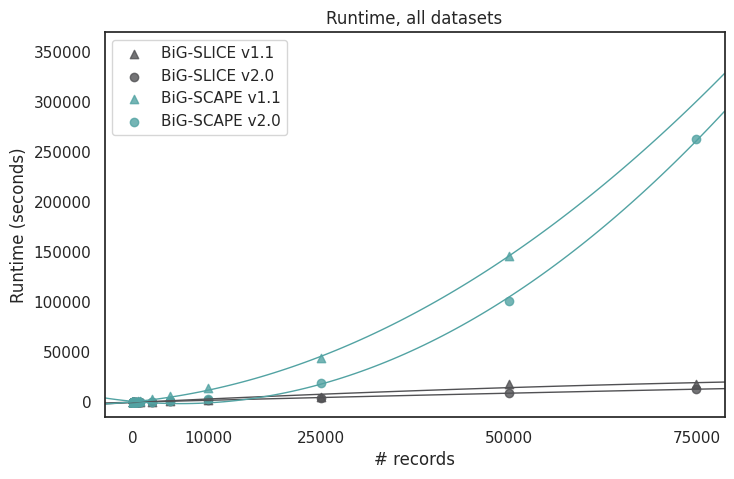

In [119]:
fig, axes = plt.subplots(1, 1, figsize=(8, 5))

### total runtimes, all sizes


## a) total runtimes for all sample sizes

## trend lines first
# bigslice v1
sns.regplot(
    label="BiG-SLICE v1.1",
    ax=axes,
    data=totals[totals["Tool"].str.contains("BiG-SLICE v1.1")],
    x="size",
    y="total",
    marker="^",
    color=COLORS["bigslice_grey"],
    truncate=False,
    order=2,
    line_kws={"linewidth": 1},
    ci=None,
)
# bigslice v2
sns.regplot(
    label="BiG-SLICE v2.0",
    ax=axes,
    data=totals[totals["Tool"].str.contains("BiG-SLICE v2.0")],
    x="size",
    y="total",
    marker="o",
    color=COLORS["bigslice_grey"],
    truncate=False,
    order=2,
    line_kws={"linewidth": 1},
    ci=None,
)
# bigscape v1
sns.regplot(
    label="BiG-SCAPE v1.1",
    ax=axes,
    data=totals[totals["Tool"].str.contains("BiG-SCAPE v1.1")],
    x="size",
    y="total",
    marker="^",
    color=COLORS["bigscape_blue"],
    truncate=False,
    order=2,
    line_kws={"linewidth": 1},
    ci=None,
)
# bigscape v2
sns.regplot(
    label="BiG-SCAPE v2.0",
    ax=axes,
    data=totals[totals["Tool"].str.contains("BiG-SCAPE v2.0")],
    x="size",
    y="total",
    marker="o",
    color=COLORS["bigscape_blue"],
    truncate=False,
    order=2,
    line_kws={"linewidth": 1},
    ci=None,
)

# title
axes.set_title("Runtime, all datasets")

# x axis options
axes.set_xlabel("# records")
axes.set_xticks([0, 10000, 25000, 50000, 75000])

# y axis options
axes.set_ylabel("Runtime (seconds)")

# legend
axes.legend(loc="upper left")


# axes[0, 0].set_xlim(0, 75000)
axes.set_ylim(-15000, 370000)

## b) total runtimes for sample sizes <= 10000
# generate plot

fig.savefig("bigscape_runtimes_totals_full.svg")

/tmp/ipykernel_52463/2849192325.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data=totals[totals["Tool"].str.contains("BiG-SLICE v1.1")][totals["size"] <= 10000],
/tmp/ipykernel_52463/2849192325.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data=totals[totals["Tool"].str.contains("BiG-SLICE v2.0")][totals["size"] <= 10000],
/tmp/ipykernel_52463/2849192325.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data=totals[totals["Tool"].str.contains("BiG-SCAPE v1.1")][totals["size"] <= 10000],
/tmp/ipykernel_52463/2849192325.py:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data=totals[totals["Tool"].str.contains("BiG-SCAPE v2.0")][totals["size"] <= 10000],


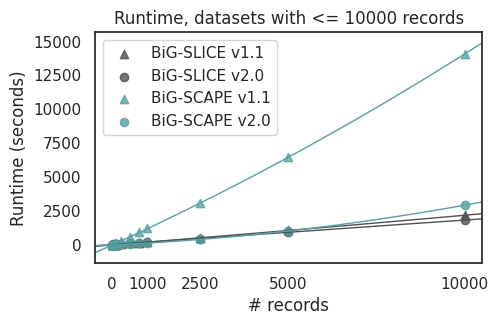

In [115]:
fig, axes = plt.subplots(1, 1, figsize=(5, 3))

## b) total runtimes for sample sizes <= 10000
# generate plot

## trend lines first
# bigslice v1
sns.regplot(
    label="BiG-SLICE v1.1",
    ax=axes,
    data=totals[totals["Tool"].str.contains("BiG-SLICE v1.1")][totals["size"] <= 10000],
    x="size",
    y="total",
    marker="^",
    color=COLORS["bigslice_grey"],
    truncate=False,
    order=2,
    line_kws={"linewidth": 1},
    ci=None,
)
# bigslice v2
sns.regplot(
    label="BiG-SLICE v2.0",
    ax=axes,
    data=totals[totals["Tool"].str.contains("BiG-SLICE v2.0")][totals["size"] <= 10000],
    x="size",
    y="total",
    marker="o",
    color=COLORS["bigslice_grey"],
    truncate=False,
    order=2,
    line_kws={"linewidth": 1},
    ci=None,
)
# bigscape v1
sns.regplot(
    label="BiG-SCAPE v1.1",
    ax=axes,
    data=totals[totals["Tool"].str.contains("BiG-SCAPE v1.1")][totals["size"] <= 10000],
    x="size",
    y="total",
    marker="^",
    color=COLORS["bigscape_blue"],
    truncate=False,
    order=2,
    line_kws={"linewidth": 1},
    ci=None,
)
# bigscape v2
sns.regplot(
    label="BiG-SCAPE v2.0",
    ax=axes,
    data=totals[totals["Tool"].str.contains("BiG-SCAPE v2.0")][totals["size"] <= 10000],
    x="size",
    y="total",
    marker="o",
    color=COLORS["bigscape_blue"],
    truncate=False,
    order=2,
    line_kws={"linewidth": 1},
    ci=None,
)

# title
axes.set_title("Runtime, datasets with <= 10000 records")

# x axis options
axes.set_xlabel("# records")
axes.set_xticks([0, 1000, 2500, 5000, 10000])

# y axis options
axes.set_ylabel("Runtime (seconds)")

# legend
axes.legend(loc="upper left")

fig.savefig("bigscape_runtimes_totals_sub_10000.svg", pad_inches=0.5, bbox_inches="tight")

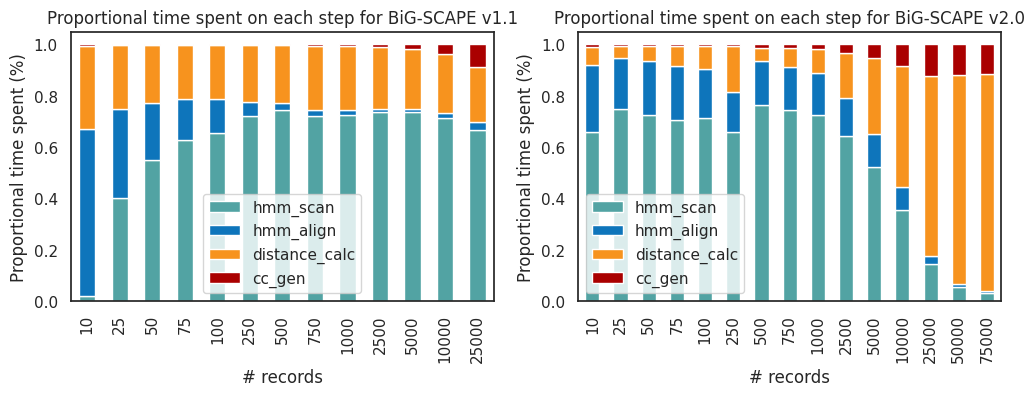

In [114]:

### runtime proportional time spent
fig, axes = plt.subplots(1, 2, figsize=(12, 3.5))


## c) proportional time spent on each step for v1
# generate plot
v1_prop_time_colors = [
    COLORS["bigscape_blue"],
    COLORS["dark_blue"],
    COLORS["orange_i_found_on_bigscape_image"],
    COLORS["antismash_red"]
]
bigscape_v1_avg_prop.plot(ax=axes[0], kind='bar', stacked=True, color=v1_prop_time_colors)

# title
axes[0].set_title("Proportional time spent on each step for BiG-SCAPE v1.1")

# x axis options
axes[0].set_xlabel("# records")

# y axis options
axes[0].set_ylabel("Proportional time spent (%)")

# set legend to be in the bottom center
axes[0].legend(loc="lower center", bbox_to_anchor=(0.5, 0.0))

## d) proportional time spent on each step for v2
# generate plot
v2_prop_time_colors = [
    COLORS["bigscape_blue"],
    COLORS["dark_blue"],
    COLORS["orange_i_found_on_bigscape_image"],
    COLORS["antismash_red"],
]
bigscape_v2_avg_prop.plot(ax=axes[1], kind='bar', stacked=True, color=v2_prop_time_colors)

# title
axes[1].set_title("Proportional time spent on each step for BiG-SCAPE v2.0")

# x axis options
axes[1].set_xlabel("# records")

# y axis options
axes[1].set_ylabel("Proportional time spent (%)")

# set legend to be in the bottom left
axes[1].legend(loc="lower left", bbox_to_anchor=(0.0, 0.0))



# save as svg
fig.savefig("bigscape_runtimes_prop.svg", pad_inches=0.5, bbox_inches="tight")

/tmp/ipykernel_52463/907237620.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(["Legacy", "Simple extend", "Greedy"])
/tmp/ipykernel_52463/907237620.py:31: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0].legend().remove()
/tmp/ipykernel_52463/907237620.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(["Legacy", "Protocluster", "Protocore"])
/tmp/ipykernel_52463/907237620.py:50: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[1].legend().remove()


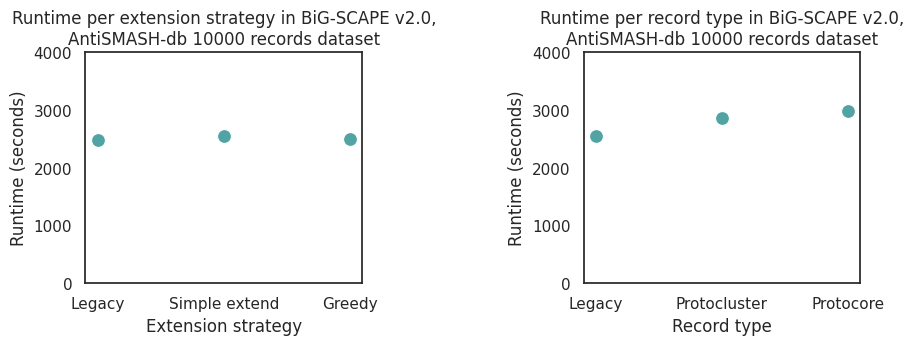

In [107]:
# collate into one image

fig, axes = plt.subplots(1, 2, figsize=(10, 3))
ax = fig.gca()
a = ax.scatter([0],[0], marker='^')
b = ax.scatter([0],[0], marker='o')
triangle_mk, = a.get_paths()
dot_mk, = b.get_paths()
a.remove()
b.remove()


## 10k antismash-db dataset

### runtime per extension strategy
strategies = mode_10k_totals[mode_10k_totals.index.isin(["legacy", "simple", "greedy"])]
sns.scatterplot(
    ax=axes[0],
    data=strategies,
    x=strategies.index,
    y="total",
    s=100,
    color=COLORS["bigscape_blue"],
)
axes[0].set_title("Runtime per extension strategy in BiG-SCAPE v2.0,\nAntiSMASH-db 10000 records dataset")
axes[0].set_xlabel("Extension strategy")
# change the tick labels. this depends on the correct order of samples so be careful
axes[0].set_xticklabels(["Legacy", "Simple extend", "Greedy"])
axes[0].set_ylabel("Runtime (seconds)")
axes[0].set_ylim(0, 4000)
axes[0].legend().remove()


### runtime per record type
record_types = mode_10k_totals[mode_10k_totals.index.isin(["legacy", "protocluster", "proto_core"])]
sns.scatterplot(
    ax=axes[1],
    data=record_types,
    x=record_types.index,
    y="total",
    s=100,
    color=COLORS["bigscape_blue"]
)
axes[1].set_title("Runtime per record type in BiG-SCAPE v2.0,\nAntiSMASH-db 10000 records dataset")
axes[1].set_xlabel("Record type")
# change the tick labels. this depends on the correct order of samples so be careful
axes[1].set_xticklabels(["Legacy", "Protocluster", "Protocore"])
axes[1].set_ylabel("Runtime (seconds)")
axes[1].set_ylim(0, 4000)
axes[1].legend().remove()

# increase margins
plt.subplots_adjust(hspace=0.5)
plt.subplots_adjust(wspace=0.8)



# save as svg
fig.savefig("bigscape_v2_option_runtimes.svg")
